In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import gc

In [2]:
# Define data transforms
transform = transforms.Compose([
    transforms.RandomCrop(256, padding=32, padding_mode='reflect'), 
    transforms.ToTensor(),
    transforms.Normalize((0.4722, 0.4815, 0.4019),(0.2427, 0.2408, 0.2654))
])


transform_val = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.4722, 0.4815, 0.4019),(0.2427, 0.2408, 0.2654))
])

# Define paths to your data directories
train_data_dir = '/kaggle/input/birds25/Birds_25/train'
val_data_dir = '/kaggle/input/birds25/Birds_25/val'

# Create datasets
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
val_dataset = ImageFolder(root=val_data_dir, transform=transform_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Labels: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']
tensor([22, 22,  8,  6, 20,  1, 24, 23, 23,  5,  4,  5,  8, 14, 10, 14, 15, 23,
         0,  0,  1, 17,  5,  8,  7, 22, 16, 18, 11, 15, 23,  5])
torch.Size([32, 3, 256, 256]) torch.Size([32])


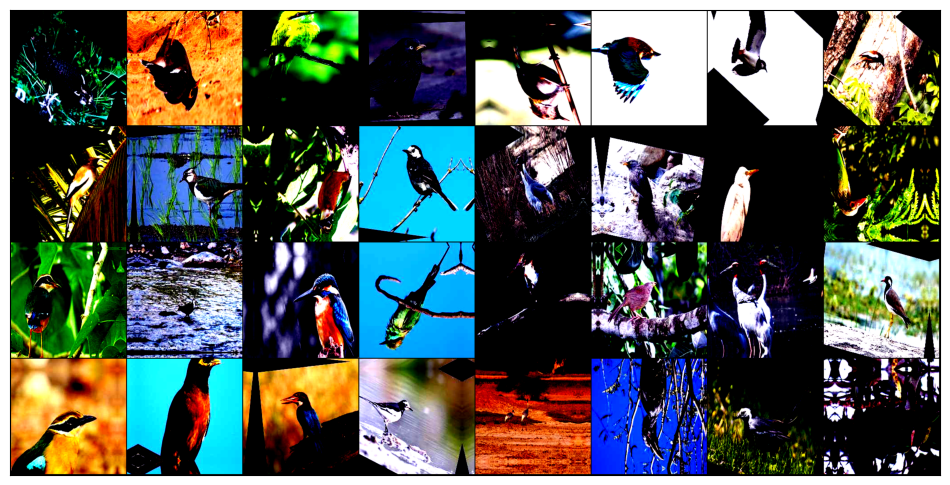

In [4]:
# Accessing labels:
print("Labels:", train_dataset.classes)

examples = iter(train_loader)
samples, labels = next(examples)
print(labels)
print(samples.shape, labels.shape)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

# Accessing labels:
print("Labels:", train_dataset.classes)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classes =  ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']

In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.downsample:
            x = self.downsample(x)
        identity = x
            
        out = self.relu(self.batch1(self.conv1(x)))
        out = self.batch2(self.conv2(out))
        
        out += identity
        out = self.relu(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=25):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1])
        self.layer3 = self._make_layer(block, 64, layers[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=3, stride=2,padding=1),
                nn.BatchNorm2d(planes)
            )

        layers = []
        self.inplanes = planes
        layers.append(block(self.inplanes, planes,1, downsample))
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
       
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1) 
        x = self.fc(x)

        return x
    
    def eval(self,num_epochs=1,learning_rate=0.0001):
        criterion = nn.CrossEntropyLoss()
        total_step = len(train_loader)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                del images, labels, outputs
                torch.cuda.empty_cache()
                gc.collect()
                
                if (i+1)%500 == 0:
                    print('epoch {}/{}, step {}/{}, loss = {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [8]:
num_layers = 2
num_classes = 25
num_epochs = 50 #40
learning_rate = 0.0001
model = ResNet(ResBlock, [num_layers, num_layers, num_layers]).to(device)
# model.load_state_dict(torch.load('/kaggle/input/my-model40/my_model40.pth'))
model.eval(num_epochs,learning_rate)
torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

epoch 1/50, step 500/920, loss = 3.1872
epoch 2/50, step 500/920, loss = 2.8549
epoch 3/50, step 500/920, loss = 2.7674
epoch 4/50, step 500/920, loss = 2.6674
epoch 5/50, step 500/920, loss = 2.7157
epoch 6/50, step 500/920, loss = 2.8036
epoch 7/50, step 500/920, loss = 2.6972
epoch 8/50, step 500/920, loss = 2.5357
epoch 9/50, step 500/920, loss = 2.4484
epoch 10/50, step 500/920, loss = 2.7220
epoch 11/50, step 500/920, loss = 2.3161
epoch 12/50, step 500/920, loss = 2.5277
epoch 13/50, step 500/920, loss = 2.3098
epoch 14/50, step 500/920, loss = 2.3556
epoch 15/50, step 500/920, loss = 2.3407
epoch 16/50, step 500/920, loss = 2.3831
epoch 17/50, step 500/920, loss = 2.1580
epoch 18/50, step 500/920, loss = 2.0911
epoch 19/50, step 500/920, loss = 2.4463
epoch 20/50, step 500/920, loss = 2.2311
epoch 21/50, step 500/920, loss = 2.2200
epoch 22/50, step 500/920, loss = 2.2676
epoch 23/50, step 500/920, loss = 2.1964
epoch 24/50, step 500/920, loss = 2.2627
epoch 25/50, step 500/920

In [9]:
#validate
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(25)]
    n_class_samples = [0 for _ in range(25)]
    num = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predicted == labels).sum().item()
        m = labels.shape[0]
        for i in range(m):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        del images,labels,outputs
        num += 1
        if (num >= 235):
            break

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network for val: {acc} %')

    for i in range(25):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of for val {classes[i]}: {acc} %')

Accuracy of the network for val: 46.569148936170215 %
Accuracy of for val Asian-Green-Bee-Eater: 55.59322033898305 %
Accuracy of for val Brown-Headed-Barbet: 17.445482866043612 %
Accuracy of for val Cattle-Egret: 67.85714285714286 %
Accuracy of for val Common-Kingfisher: 72.42524916943522 %
Accuracy of for val Common-Myna: 17.741935483870968 %
Accuracy of for val Common-Rosefinch: 23.711340206185568 %
Accuracy of for val Common-Tailorbird: 37.13355048859935 %
Accuracy of for val Coppersmith-Barbet: 20.477815699658702 %
Accuracy of for val Forest-Wagtail: 40.26402640264026 %
Accuracy of for val Gray-Wagtail: 26.621160409556314 %
Accuracy of for val Hoopoe: 63.10344827586207 %
Accuracy of for val House-Crow: 56.38297872340426 %
Accuracy of for val Indian-Grey-Hornbill: 44.52054794520548 %
Accuracy of for val Indian-Peacock: 71.9869706840391 %
Accuracy of for val Indian-Pitta: 34.42622950819672 %
Accuracy of for val Indian-Roller: 56.45161290322581 %
Accuracy of for val Jungle-Babbler: 47

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/my_model.pth')